In [ ]:
# Install necessary libraries
!pip install matplotlib openpyxl pymatgen
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

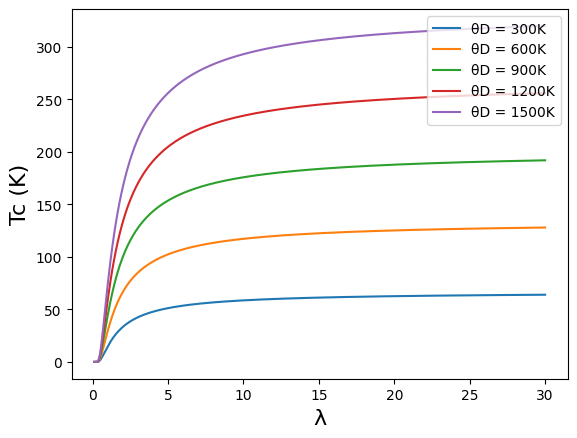

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For λ <= 0.2, this equation will overflow and give an unrealistic value for Tc. This is because the argument of the exponential function becomes very large negative number, causing overflow.
# This will set Tc to 0 when λ <= 0.2, and calculate normally when λ > 0.2
def mcmillan(T_D, lambda_, mu_star):
    return (T_D / 1.45) * np.exp(-1.04 * (1 + lambda_) / (lambda_ - mu_star * (1 + 0.62 * lambda_))) * (lambda_ > 0.2) 

theta_D_list = [300, 600, 900, 1200, 1500]
lambda_range = np.linspace(0.1, 30.0, 500)
mu_star = 0.13

# Plot Tc vs lambda for each theta_D value
for theta_D in theta_D_list:
    Tc = mcmillan(theta_D, lambda_range, mu_star)
    plt.plot(lambda_range, Tc, label=f'θD = {theta_D}K')

# Add labels and legend
plt.xlabel('λ', fontsize=16)
plt.ylabel('Tc (K)', fontsize=16)
plt.legend(loc='upper right')

plt.show()

In [ ]:
import numpy as np
from pymatgen.io.cif import CifParser
from pymatgen.core.structure import Structure
from collections import defaultdict
from google.colab import drive
import pandas as pd

# Constants and input file definitions
hbar = 6.582e-16 # eVs
kb = 8.617e-5 # eV/K
e = 1.602e-19 # C
m0 = 9.109e-31 # kg
r = 10 # effective mass ratio(m*/m0)
c = 6.242e18 # convert unit(1 kgm^2/s^2 = 1 J = 6.242e18 eV)
gap_ratio = 6 # energy gap to Tc ratio
beta0 = 1.01879 # eigenvalue
beta1 = 2.33811 # eigenvalue

# Load the crystal structure from a CIF file
#parser = CifParser("/content/gdrive/MyDrive/LK99+Cu.cif")    # For LK99
#parser = CifParser("/content/gdrive/MyDrive/Pb Apatite.cif")   # For Pb Apatite
#parser = CifParser("/content/gdrive/MyDrive/YBCO.cif")    # For YBCO
#parser = CifParser("/content/gdrive/MyDrive/Bi2223.cif")    # For Bi2223
#parser = CifParser("/content/gdrive/MyDrive/LSCO.cif")    # For LSCO
#parser = CifParser("/content/gdrive/MyDrive/Tl2223.cif")    # For Tl2223
parser = CifParser("/content/gdrive/MyDrive/Hg1223.cif")    # For Hg1223
structure = parser.get_structures()[0]

# Extract site labels from cif file
cif_dict = parser.as_dict()
first_block = list(cif_dict.values())[0]
labels = first_block.get('_atom_site_label')

# Ensure the labels list is long enough
labels = labels * (len(structure) // len(labels) + 1)

# Define atomic charges
#atomic_charges = {'Pb': 2, 'Cu': 2, 'O': -2, 'P': 5}   # For Pb Apatite or LK99
#atomic_charges = {'Cu2.27+': 2, 'Ba2+': 2, 'O2-': -2, 'Y3+': 3}   # For YBCO
#atomic_charges = {'Cu': 2, 'Bi': 3, 'O': -2, 'Sr': 2, 'Ca': 2}   # For Bi2223
#atomic_charges = {'Cu2.13+': 2, 'La3+': 3, 'O2-': -2, 'Sr2+': 2}   # For LSCO
#atomic_charges = {'Cu': 2, 'Tl': 3, 'O': -2, 'Sr': 2, 'Ca': 2}   # For Tl2223
atomic_charges = {'Cu': 2, 'Hg': 2, 'O': -2, 'Ba': 2, 'Ca': 2}   # For Hg1223

# Define vacuum permittivity constant
epsilon_0 = 8.854187817e-12

# Create a list to store the data for the Excel file
data_list = []

# Iterate over all pairs of sites
for i in range(len(structure)):
    for j in range(i + 1, len(structure)):
        # Get site information
        site1 = structure[i]
        label1 = labels[i]
        x1, y1, z1 = site1.coords
        charge1 = sum([atomic_charges[str(sp)] * occu for sp, occu in site1.species.items()])

        site2 = structure[j]
        label2 = labels[j]
        x2, y2, z2 = site2.coords
        charge2 = sum([atomic_charges[str(sp)] * occu for sp, occu in site2.species.items()])

        # Calculate distance vector and electric field
        r_vec = np.array([x2 - x1, y2 - y1, z2 - z1])
        r = np.linalg.norm(r_vec)
        E_field = (1 / (4 * np.pi * epsilon_0)) * (charge1 / r**3) * r_vec
        E_magnitude = np.linalg.norm(E_field)

        # Calculate Delta_E (meV) and Tc (K)
        Delta_E = (beta1 - beta0) * ((hbar**2 * E_magnitude**2) / (2 * r * m0 * c))**(1/3)
        Tc = Delta_E / (kb * gap_ratio)
        T_E = Delta_E / kb

        # Add electric field calculation and Tc to data list
        data_list.append([label1, label2, i, j,tuple([round(coord, 4) for coord in site1.coords]), tuple([round(coord, 4) for coord in site2.coords]), r, "{:.2E}".format(E_field[0]), "{:.2E}".format(E_field[1]), "{:.2E}".format(E_field[2]), "{:.2E}".format(E_magnitude), round(T_E, 2), round(Delta_E, 2), round(Tc, 2)])

# Create a DataFrame from the data
df = pd.DataFrame(data_list, columns=['Atom 1', 'Atom 2', 'Index 1', 'Index 2', 'Coordinates 1', 'Coordinates 2', 'Distance (Å)', 'Electric Field X (V/m)', 'Electric Field Y (V/m)', 'Electric Field Z (V/m)', 'Electric Field Magnitude (V/m)', 'T_E (K)', 'ΔE (meV)', 'Tc (K)'])

# Filter DataFrame based on desired pairs and desired distance
#desired_pairs = [('Pb1', 'O1'), ('Pb1', 'O2'), ('Pb1', 'O3'), ('Pb3', 'O1'), ('Pb3', 'O2'), ('Pb3', 'O3')]   # For Pb Apatite or LK99
#desired_pairs = [('Cu2', 'O4')]   # For YBCO    ;5090
#desired_pairs = [('Cu2', 'O3')]   # For Bi2223  ;3126.51     3/5
#desired_pairs = [('Cu1', 'O2')]   # For LSCO   ;4970
#desired_pairs = [('Cu(3)', 'O(3)')]   # For Tl2223   ;2610          3/5
#desired_pairs = [('Cu2', 'O3')]   # For Hg1223   ;4000
desired_distance_min, desired_distance_max = 3, 4

filtered_df = df[
    (df['Distance (Å)'].between(desired_distance_min, desired_distance_max)) &
    (df.apply(lambda row: (row['Atom 1'], row['Atom 2']) in desired_pairs or
                          (row['Atom 2'], row['Atom 1']) in desired_pairs, axis=1))
]

# Calculate the total vector sum of electric fields, magnitude, Delta_E, Tc
# If there's only one desired pair, directly use the values
if len(filtered_df) == 1:
    total_electric_field = filtered_df[['Electric Field X (V/m)', 'Electric Field Y (V/m)', 'Electric Field Z (V/m)']].apply(pd.to_numeric).iloc[0].values
    total_electric_field_magnitude = pd.to_numeric(filtered_df['Electric Field Magnitude (V/m)'].values[0])
    
    total_T_E = filtered_df['T_E (K)'].values[0]
    total_Delta_E = filtered_df['ΔE (meV)'].values[0]
    total_Tc = filtered_df['Tc (K)'].values[0]
else:
    # Calculate the total vector sum of electric fields
    total_electric_field = filtered_df[['Electric Field X (V/m)', 'Electric Field Y (V/m)', 'Electric Field Z (V/m)']].apply(pd.to_numeric).sum().values
    total_electric_field_magnitude = np.linalg.norm(total_electric_field)
    
    total_Delta_E = (beta1 - beta0) * ((hbar**2 * total_electric_field_magnitude**2) / (2 * r * m0 * c))**(1/3)
    total_Tc = total_Delta_E / (kb * gap_ratio)
    total_T_E = total_Delta_E / kb

# Calculate the average distance
average_distance = filtered_df['Distance (Å)'].mean()

# Create a new DataFrame for the summary of the calculated values
summary_df = pd.DataFrame({'Distance (Å)': [f"{average_distance:.2f}"],
                           'Electric Field X (V/m)': [format(total_electric_field[0], '.2E')],
                           'Electric Field Y (V/m)': [format(total_electric_field[1], '.2E')],
                           'Electric Field Z (V/m)': [format(total_electric_field[2], '.2E')],
                           'Electric Field Magnitude (V/m)': [format(total_electric_field_magnitude, '.2E')],
                           'T_E (K)': [f"{total_T_E:.2f}"],
                           'ΔE (meV)': [f"{total_Delta_E:.2f}"],
                           'Tc (K)': [f"{total_Tc:.2f}"]})

# Append summary to filtered DataFrame using pd.concat
final_df = pd.concat([filtered_df, summary_df], ignore_index=True)

# Save original and filtered DataFrames to Excel file in your Google Drive
with pd.ExcelWriter('/content/gdrive/MyDrive/output.xlsx') as writer:
    df.to_excel(writer, sheet_name='Sheet1', index=False, float_format="%.2E")
    final_df.to_excel(writer, sheet_name='Sheet2', index=False, float_format="%.2E")


Predictions for new X-values: [ 50  91 110 120 133 400]
Predicted y-values (Random Forest): [0.54 0.6  1.13 1.29 1.54 2.43]


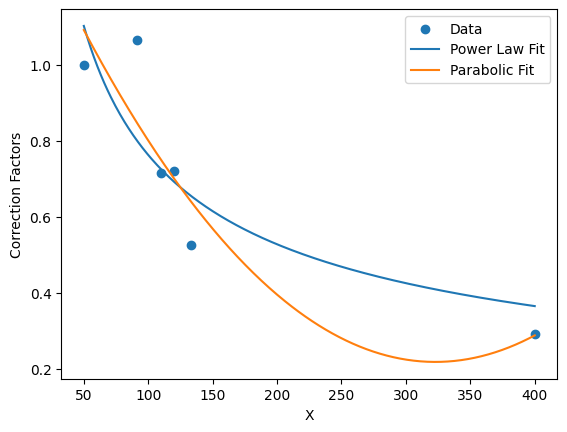

Corrected y-value at x = 50 using Power Law Fit: 0.5967
Corrected y-value at x = 50 using Parabolic Fit: 0.5909

Corrected y-value at x = 91 using Power Law Fit: 0.4837
Corrected y-value at x = 91 using Parabolic Fit: 0.5120

Corrected y-value at x = 110 using Power Law Fit: 0.8198
Corrected y-value at x = 110 using Parabolic Fit: 0.8476

Corrected y-value at x = 120 using Power Law Fit: 0.8943
Corrected y-value at x = 120 using Parabolic Fit: 0.9054

Corrected y-value at x = 133 using Power Law Fit: 1.0070
Corrected y-value at x = 133 using Parabolic Fit: 0.9848

Corrected y-value at x = 400 using Power Law Fit: 0.8873
Corrected y-value at x = 400 using Parabolic Fit: 0.7003

Tc: 50
Power Law Fit - Tc (BCS): 1141.96, Tc (McMillan): 69.88, Tc (Allen-Dynes): 62.88
Parabolic Fit - Tc (BCS): 1123.25, Tc (McMillan): 67.36, Tc (Allen-Dynes): 60.65

Tc: 91
Power Law Fit - Tc (BCS): 795.68, Tc (McMillan): 28.25, Tc (Allen-Dynes): 25.72
Parabolic Fit - Tc (BCS): 891.85, Tc (McMillan): 37.67, T

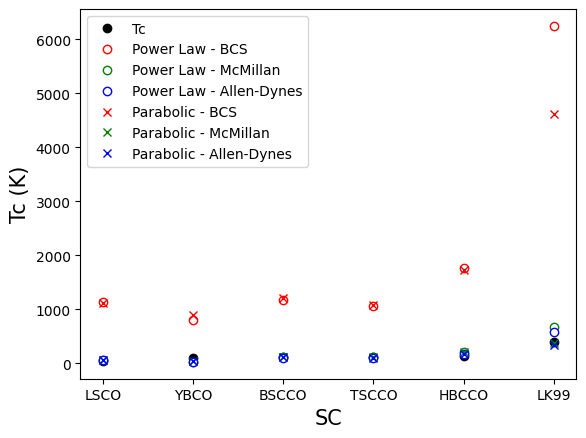

In [26]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Load data
data = pd.DataFrame({
    'x': [20.80, 27.96, 40.12, 59.08, 71.07, 73.13, 73.13, 75.18, 76.97, 78.13, 81.00, 81.09, 82.25, 82.16, 83.95, 85.92, 87.35, 89.31, 86.99, 90.21, 94.23, 90.12, 123.12,
          1.16, 0.85, 1.08, 0.52, 3.40, 3.72, 4.16, 2.38, 7.19, 0.39, 5.30, 0.55, 9.22, 0.92, 0.49, 0.09, 4.48, 0.012, 1.69, 0.65, 0.14, 4.88, 6.00, 1.38, 0, 0, 0, 0, 0, 0, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 5.6, 6.4, 5.2, 17.1, 18.5, 17.8, 20, 16, 
          190, 134, 161, 161, 145, 7.7, 164.8, 127.2, 192.5, 64.4, 240, 5.1, 0, 8.7, 5.3, 7.4, 3.95],

    'y': [0.32, 0.36, 0.28, 0.51, 0.54, 0.52, 0.55, 0.56, 0.54, 0.58, 0.58, 0.56, 0.55, 0.54, 0.583, 0.60, 0.62, 0.63, 0.56, 0.57, 0.66, 0.69, 1.11,
          0.38, 0.38, 0.4, 0.38, 0.69, 0.60, 1, 0.71, 1.12, 0.38, 0.60, 0.41, 0.82, 0.41, 0.38, 0.34, 0.65, 0.28, 0.46, 0.39, 0.34, 0.81, 0.93, 0.56, 0.35, 0.14, 0.11, 0.15, 0.16, 0.13, 
          0.12, 0.15, 0.20, 0.05, 0.27, 0.51, 0.62, 0.47, 0.66, 1.40, 1.63, 1.43, 0.89, 1.7, 1.75, 1.7, 1.46,  
          2, 1.46, 1.71, 1.68, 1.90, 0.67, 2.3, 1.85, 1.93, 1.68, 2.77, 0.61, 1.7, 0.87, 0.63, 0.68, 0.49]
})

# Define input and output arrays
X = np.array(data['x']).reshape(-1, 1)
y = np.array(data['y'])

# Train Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X, y)

# Predict new y-values for new X-values
new_X = np.array([[50], [91], [110], [120], [133], [400]])  # example new X-values
new_y_rf = model_rf.predict(new_X)

# Round predicted values to 2 decimal places and print results
print(f'Predictions for new X-values: {new_X.flatten()}')
print(f'Predicted y-values (Random Forest): {new_y_rf.round(2)}')


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Data
X = np.array([50, 91, 110, 120, 133, 400])
Pred_Y = np.array([0.54, 0.60, 1.13, 1.29, 1.54, 2.43])
Exact_Y = np.array([0.54, 0.64, 0.81, 0.93, 0.81, 0.71])
Correction_Factors = Exact_Y / Pred_Y

# Functions to fit
def power_law(x, a, b):
    return a * x**(-b)

def parabolic(x, a, b, c):
    return a * x**2 + b * x + c

# Fit functions
power_law_params, _ = curve_fit(power_law, X, Correction_Factors, bounds=([0, 0], [np.inf, np.inf]))
parabolic_params, _ = curve_fit(parabolic, X, Correction_Factors)

# Plot correction factors
plt.scatter(X, Correction_Factors, label='Data')

# Plot fitting function results
x_values = np.linspace(50, 400, 400)

plt.plot(x_values, power_law(x_values, *power_law_params), label='Power Law Fit')
plt.plot(x_values, parabolic(x_values, *parabolic_params), label='Parabolic Fit')

# Labels and legend
plt.xlabel('X')
plt.ylabel('Correction Factors')
plt.legend(loc='best')

plt.show()

# Calculation of corrected y-values
predicted_y_values_rf = np.array(new_y_rf)  # From the Random Forest code you provided earlier

for i, input_x in enumerate(X):
    power_law_y = power_law(input_x, *power_law_params)
    parabolic_y = parabolic(input_x, *parabolic_params)

    corrected_y_values_power_law = predicted_y_values_rf[i] * power_law_y
    corrected_y_values_parabolic = predicted_y_values_rf[i] * parabolic_y

    print(f"Corrected y-value at x = {input_x} using Power Law Fit: {corrected_y_values_power_law:.4f}")
    print(f"Corrected y-value at x = {input_x} using Parabolic Fit: {corrected_y_values_parabolic:.4f}")
    print()




# Constants
mu_star = 0.13
values = [
    {'x': 50, 'theta_D': 383, 'T_E': 4970},
    {'x': 91, 'theta_D': 426, 'T_E': 5090},
    {'x': 110, 'theta_D': 334, 'T_E': 3127},
    {'x': 120, 'theta_D': 226, 'T_E': 2610},
    {'x': 133, 'theta_D': 200, 'T_E': 4000},
    {'x': 400, 'theta_D': 280, 'T_E': 16635},
]

def mcmillan0(T_D, lambda_):        # BCS
    T_c = 1.14*T_D*np.exp(-1/lambda_) * (lambda_ > 0.2)
    return T_c

def mcmillan1(T_D, lambda_, mu_star):           # McMillan
    T_c = (T_D / 1.45) * np.exp(-1.04 * (1 + lambda_) / (lambda_ - mu_star * (1 + 0.62 * lambda_))) * (lambda_ > 0.2)
    return T_c

def mcmillan2(T_D, lambda_, mu_star):           # Allen-Dynes
    f1 = (1 + (lambda_ / (2.46 * (1 + 3.8 * mu_star)))**(3/2)) ** (1 / 3)
    f2_star = 1 + (0.0241 - 0.0735 * mu_star) * lambda_ ** 2
    T_c = (T_D / 1.45) * np.exp(-(1.04 * (1 + lambda_) / (lambda_ - mu_star * (1 + 0.62 * lambda_))) * f1 * f2_star) * (lambda_ > 0.2)
    return T_c

# Lambda and T_E values
predicted_y_lambda_power_law = np.array(new_y_rf) * power_law(X, *power_law_params)
predicted_y_lambda_parabolic = np.array(new_y_rf) * parabolic(X, *parabolic_params)

for i, data in enumerate(values):
    T_D = data['theta_D'] + data['T_E']
    lambda_power_law = predicted_y_lambda_power_law[i]
    lambda_parabolic = predicted_y_lambda_parabolic[i]

    T_c0_power_law = mcmillan0(T_D, lambda_power_law)
    T_c0_parabolic = mcmillan0(T_D, lambda_parabolic)

    T_c1_power_law = mcmillan1(T_D, lambda_power_law, mu_star)
    T_c1_parabolic = mcmillan1(T_D, lambda_parabolic, mu_star)

    T_c2_power_law = mcmillan2(T_D, lambda_power_law, mu_star)
    T_c2_parabolic = mcmillan2(T_D, lambda_parabolic, mu_star)

    print(f"Tc: {data['x']}")
    print(f"Power Law Fit - Tc (BCS): {T_c0_power_law:.2f}, Tc (McMillan): {T_c1_power_law:.2f}, Tc (Allen-Dynes): {T_c2_power_law:.2f}")
    print(f"Parabolic Fit - Tc (BCS): {T_c0_parabolic:.2f}, Tc (McMillan): {T_c1_parabolic:.2f}, Tc (Allen-Dynes): {T_c2_parabolic:.2f}")
    print()



import matplotlib.pyplot as plt

samples = ['LSCO', 'YBCO', 'BSCCO', 'TSCCO', 'HBCCO', 'LK99']

Tc_values = []

Tc_BCS_power_law_values = []
Tc_McMillan_power_law_values = []
Tc_AllenDynes_power_law_values = []

Tc_BCS_parabolic_values = []
Tc_McMillan_parabolic_values = []
Tc_AllenDynes_parabolic_values = []

for i, data in enumerate(values):
   T_D = data['theta_D'] + data['T_E']
   lambda_power_law = predicted_y_lambda_power_law[i]
   lambda_parabolic = predicted_y_lambda_parabolic[i]

   Tc_values.append(data['x'])
   Tc_BCS_power_law_values.append(mcmillan0(T_D, lambda_power_law))
   Tc_McMillan_power_law_values.append(mcmillan1(T_D, lambda_power_law, mu_star))
   Tc_AllenDynes_power_law_values.append(mcmillan2(T_D, lambda_power_law, mu_star))

   Tc_BCS_parabolic_values.append(mcmillan0(T_D, lambda_parabolic))
   Tc_McMillan_parabolic_values.append(mcmillan1(T_D, lambda_parabolic, mu_star))
   Tc_AllenDynes_parabolic_values.append(mcmillan2(T_D, lambda_parabolic, mu_star))

x_values = range(len(samples))

# Plot the Tc values
plt.plot(x_values, Tc_values, 'ko', label="Tc")

# Plot the points for Power Law Fit with hollow circles
plt.plot(x_values, Tc_BCS_power_law_values, 'ro', mfc='white', label='Power Law - BCS')
plt.plot(x_values, Tc_McMillan_power_law_values, 'go', mfc='white', label='Power Law - McMillan')
plt.plot(x_values, Tc_AllenDynes_power_law_values, 'bo', mfc='white', label='Power Law - Allen-Dynes')

# Plot the points for Parabolic Fit
plt.plot(x_values, Tc_BCS_parabolic_values, 'rx', label='Parabolic - BCS')
plt.plot(x_values, Tc_McMillan_parabolic_values, 'gx', label='Parabolic - McMillan')
plt.plot(x_values, Tc_AllenDynes_parabolic_values, 'bx', label='Parabolic - Allen-Dynes')

# Add labels and legend
plt.xticks(x_values, samples)
plt.xlabel('SC', fontsize=15)
plt.ylabel('Tc (K)', fontsize=15)
plt.legend()
plt.show()
